## BIRDS 525 SPECIES- IMAGE CLASSIFICATION

## 1. Load Data

- **Dataset Size:** 525 bird species.
- **Images:** 84,635 training images, 2,625 test images (5 per species), and 2,625 validation images (5 per species).
- **Image Dimensions:** 224x224x3 JPG format.
- **Data Structure:** Convenient subdirectories for each species.
- **Additional File:** `birds.csv` contains file paths, class labels, and more.

**Dataset Quality:**
- Cleaned to remove duplicate and low-quality images.
- Each image features a single bird taking up at least 50% of pixels.
- Original images, no augmentation.

**File Naming:**
- Sequential numbering, e.g., "001.jpg," "002.jpg" for training.
- Test and validation images: "1.jpg" to "5.jpg."

**Note:** Training set not balanced but has ≥130 images per species.

In [2]:
# Import Fastai libraries
from fastai.vision.all import *  # Comprehensive computer vision library
from fastcore.foundation import L  # Foundational utilities
from fastcore.xtras import Path  # Extends functionality for Path objects
from fastai.callback.fp16 import to_fp16  # Enables mixed-precision training
from fastai.callback.schedule import fit_one_cycle, lr_find  # Training schedule utilities
from fastai.data.block import CategoryBlock, DataBlock  # Define data block components
from fastai.data.transforms import (  # Data transformation functions
    get_image_files, Normalize, RandomSplitter, parent_label
)
from fastai.interpret import ClassificationInterpretation  # Interpret classification results
from fastai.learner import Learner  # Main class for model training
from fastai.vision.augment import aug_transforms, RandomResizedCrop  # Image augmentation
from fastai.vision.core import imagenet_stats  # ImageNet dataset statistics
from fastai.vision.data import ImageBlock  # Define handling of images
from fastai.vision.learner import cnn_learner  # Create CNN learners
from fastai.vision.utils import download_images, verify_images  # Image-related utilities

In [3]:
from fastai.data.transforms import get_image_files # to retrieve image files

path = Path("/kaggle/input/100-bird-species")  # Main path
train_path = path / "train"  # Training data path
val_path = path / "valid"  # Validation data path
test_path = path / "test"  # Test data path

# Define a function to get the list of image files and labels
def get_items(path):
    return get_image_files(path)  # Get a list of image files in the specified path

# Define a function to get the label from the folder name
def label_func(x):
    return x.parent.name  # Extract the label from the parent folder name

## 2. Data Preparation

**Augmentation Transforms:**
- Imported augmentation transforms to enhance dataset diversity.

**Item Transforms:**
- Images resized to a consistent width of 460 pixels.

**Batch Transforms:**
- Images resized to 224x224 pixels with a minimum scaling of 75%.
- Additional augmentations applied to batches for robustness.

These transformations ensure data consistency and introduce variability, preparing the dataset for model training.

In [4]:
# Import augmentation transforms.
from fastai.vision.augment import aug_transforms

# Item transforms: Resize images to 460 pixels width.
item_tfms = [Resize(460)]

# Batch transforms: Resize to 224 pixels with min 75% scaling and apply other augmentations.
batch_tfms = [*aug_transforms(min_scale=0.75, size=224)]

## 3. Create DataLoader

**DataBlock Configuration:**
- Utilized Fastai's DataBlock to define data processing.
- Blocks specified as (ImageBlock, CategoryBlock) for image and category data.
- `get_items` set to retrieve image files.
- Splitter configured using `GrandparentSplitter` to separate train and test sets based on directory names.
- `get_y` method defined to extract parent label as category.
- Item and batch transforms (`item_tfms` and `batch_tfms`) applied as configured.

**DataLoaders Creation:**
- Fastai DataLoaders created using the DataBlock and dataset path.
- Batch size set to 64 for efficient data loading.

These steps establish the DataLoaders required for training and validation, making the data ready for model ingestion.


In [5]:
from fastai.data.block import DataBlock, CategoryBlock
from fastai.vision.data import ImageBlock
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name="train",valid_name='test'),
    get_y=parent_label,
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)


# Create Fastai DataLoaders using the DataBlock and path to data
fastai_dls = dblock.dataloaders(path, bs=64)

Good! Let's take a look at some of our pictures then.

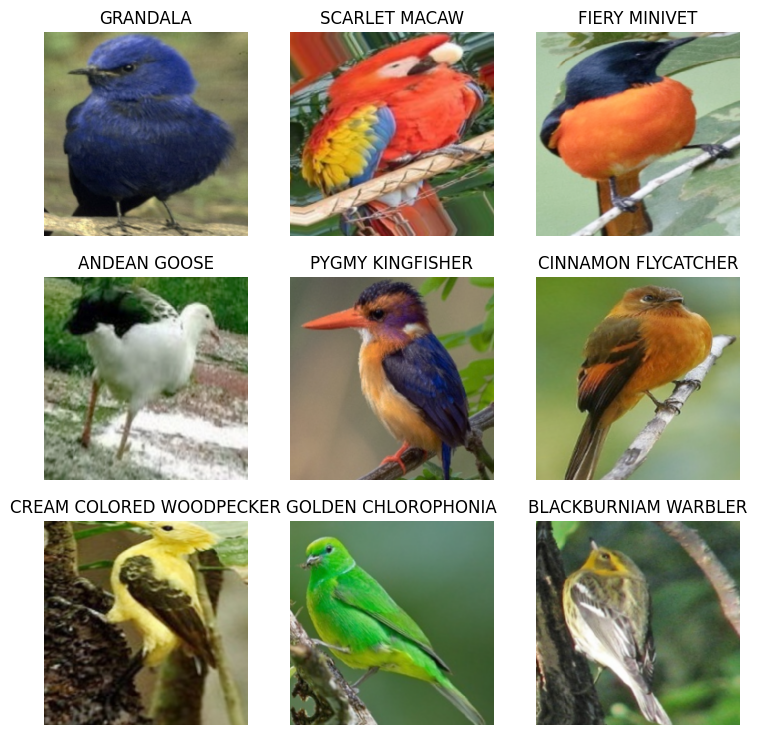

In [6]:
# Show a batch of data
fastai_dls.show_batch()

In [7]:
len(fastai_dls.vocab), fastai_dls.vocab[:10]

(525,
 (#10) ['ABBOTTS BABBLER','ABBOTTS BOOBY','ABYSSINIAN GROUND HORNBILL','AFRICAN CROWNED CRANE','AFRICAN EMERALD CUCKOO','AFRICAN FIREFINCH','AFRICAN OYSTER CATCHER','AFRICAN PIED HORNBILL','AFRICAN PYGMY GOOSE','ALBATROSS'])

In [8]:
print(fastai_dls.train_ds)
print(fastai_dls.valid_ds)
len(fastai_dls.train_ds.vocab) == len(fastai_dls.valid_ds.vocab)

(#84635) [(PILImage mode=RGB size=224x224, TensorCategory(185)),(PILImage mode=RGB size=224x224, TensorCategory(185)),(PILImage mode=RGB size=224x224, TensorCategory(185)),(PILImage mode=RGB size=224x224, TensorCategory(185)),(PILImage mode=RGB size=224x224, TensorCategory(185)),(PILImage mode=RGB size=224x224, TensorCategory(185)),(PILImage mode=RGB size=224x224, TensorCategory(185)),(PILImage mode=RGB size=224x224, TensorCategory(185)),(PILImage mode=RGB size=224x224, TensorCategory(185)),(PILImage mode=RGB size=224x224, TensorCategory(185))...]
(#2625) [(PILImage mode=RGB size=224x224, TensorCategory(185)),(PILImage mode=RGB size=224x224, TensorCategory(185)),(PILImage mode=RGB size=224x224, TensorCategory(185)),(PILImage mode=RGB size=224x224, TensorCategory(185)),(PILImage mode=RGB size=224x224, TensorCategory(185)),(PILImage mode=RGB size=224x224, TensorCategory(75)),(PILImage mode=RGB size=224x224, TensorCategory(75)),(PILImage mode=RGB size=224x224, TensorCategory(75)),(PILImag

True

In [9]:
for label in fastai_dls.valid_ds.vocab:
    if label not in fastai_dls.train_ds.vocab:
        print(label)

## 4. Create Learner (Model) & Find Learning Rate

**Pre-trained Model Configuration:**
- Imported pre-trained ResNet models (resnet34 and resnet50) from torchvision.
- Created a vision learner using the Fastai library with the ResNet-50 architecture.
- Enabled the use of pretrained weights and specified evaluation metrics, including accuracy and error rate.
- Enabled mixed-precision training using `to_fp16()` for enhanced training efficiency.

**Finding Learning Rate:**
- Utilized the `lr_find()` method to determine an optimal learning rate.
- Discovered a suitable learning rate range (`lr`) for model training, set as `slice(1e-4, 5e-3)`.

This section highlights the model configuration, including the choice of architecture, pretrained weights, and learning rate discovery, ensuring an effective setup for model training and evaluation.


In [10]:
# Import pre-trained ResNet models (resnet34 and resnet50) from torchvision.
from torchvision.models.resnet import resnet34, resnet50

# Create a vision learner using the fastai library, with the ResNet-50 architecture,
# pretrained weights, and evaluation metrics including accuracy and error rate.
# Also, enable mixed-precision training (to_fp16).
learn = vision_learner(fastai_dls, resnet50, pretrained=True, metrics=[accuracy, error_rate]).to_fp16()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 131MB/s] 


In [ ]:
# Find the optimal learning rate using the learning rate finder.
learn.lr_find()

In [24]:
# Dynamic learning rate range: Starts low and increases gradually during training.
lr = slice(1e-4, 5e-3)

## 5. Train & Save Model

**Model Performance with Resnet50 (Freezed Layers)**

| Epoch | Train Loss | Valid Loss | Accuracy | Error Rate | Time   |
|-------|------------|------------|----------|------------|--------|
| 0     | 1.2802     | 0.4474     | 0.8705   | 0.1295     | 13:50  |
| 1     | 0.7865     | 0.1838     | 0.9482   | 0.0518     | 11:06  |
| 2     | 0.4920     | 0.1074     | 0.9695   | 0.0305     | 11:17  |
| 3     | 0.3435     | 0.0671     | 0.9844   | 0.0156     | 10:44  |
| 4     | 0.2979     | 0.0590     | 0.9859   | 0.0141     | 11:12  |

**Model Training:**
- The model was trained for 5 epochs using a one-cycle learning rate policy with the specified learning rate range.
- The training results demonstrate the model's impressive performance, achieving high accuracy and low error rates.

**Model Preservation:**
- Saved the trained model with the name 'model1_freezed' for future use.
- This step ensures that the model's architecture and learned weights are preserved and can be easily loaded and deployed for various tasks.

This section provides an overview of the model's training performance, including training and validation losses, accuracy, and error rates. It also emphasizes the importance of preserving the trained model for future use.

In [ ]:
# Train the model for 5 epochs using a one-cycle learning rate policy with the specified learning rate range.
learn.fit_one_cycle(5, lr_max=lr)

# Save the trained model with the name 'model1_freezed' for future use.
learn.save('model1_freezed')

In [11]:
# Load the trained model with the name 'model1_freezed' for future use.
learn.load('model1_freezed')

## Model Interpretation

In [12]:
# Model Interpretation
# Import the ClassificationInterpretation class from fastai and create an instance 'interp' to interpret model results.

interp = ClassificationInterpretation.from_learner(learn)

# Calculate and store prediction losses and their corresponding indices.
losses, idxs = interp.top_losses()

# Check if the number of validation dataset samples, losses, and indices are equal.
print(len(fastai_dls.valid_ds) == len(losses) == len(idxs))

# Classification Report
# Print a classification report summarizing model performance.
interp.print_classification_report()

/opt/conda/lib/python3.10/site-packages/torch/amp/autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/opt/conda/lib/python3.10/site-packages/torch/cuda/amp/grad_scaler.py:120: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


True


                               precision    recall  f1-score   support

              ABBOTTS BABBLER       1.00      1.00      1.00         5
                ABBOTTS BOOBY       1.00      0.80      0.89         5
   ABYSSINIAN GROUND HORNBILL       1.00      1.00      1.00         5
        AFRICAN CROWNED CRANE       1.00      1.00      1.00         5
       AFRICAN EMERALD CUCKOO       1.00      1.00      1.00         5
            AFRICAN FIREFINCH       1.00      1.00      1.00         5
       AFRICAN OYSTER CATCHER       1.00      1.00      1.00         5
        AFRICAN PIED HORNBILL       1.00      1.00      1.00         5
          AFRICAN PYGMY GOOSE       1.00      1.00      1.00         5
                    ALBATROSS       1.00      1.00      1.00         5
               ALBERTS TOWHEE       1.00      1.00      1.00         5
         ALEXANDRINE PARAKEET       1.00      1.00      1.00         5
                ALPINE CHOUGH       0.83      1.00      0.91         5
     

In [13]:
# Most Confused
interp.most_confused()

/opt/conda/lib/python3.10/site-packages/torch/amp/autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/opt/conda/lib/python3.10/site-packages/torch/cuda/amp/grad_scaler.py:120: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


[('GILDED FLICKER', 'NORTHERN FLICKER', 2),
 ('ABBOTTS BOOBY', 'NORTHERN GANNET', 1),
 ('ALTAMIRA YELLOWTHROAT', 'CANARY', 1),
 ('AMERICAN REDSTART', 'FIERY MINIVET', 1),
 ('AMERICAN WIGEON', 'BAIKAL TEAL', 1),
 ('ANDEAN GOOSE', 'MAGPIE GOOSE', 1),
 ('AUSTRAL CANASTERO', 'AMERICAN PIPIT', 1),
 ('AUSTRAL CANASTERO', 'AZARAS SPINETAIL', 1),
 ('AUSTRAL CANASTERO', 'CHIPPING SPARROW', 1),
 ('BARROWS GOLDENEYE', 'WOOD DUCK', 1),
 ('BLACK COCKATO', 'GOLDEN EAGLE', 1),
 ('BLACK NECKED STILT', 'BANDED STILT', 1),
 ('CRESTED SHRIKETIT', 'PARUS MAJOR', 1),
 ('EASTERN YELLOW ROBIN', 'FIERY MINIVET', 1),
 ('GRANDALA', 'COMMON STARLING', 1),
 ('GRAY PARTRIDGE', 'SNOW PARTRIDGE', 1),
 ('GREAT KISKADEE', 'BIRD OF PARADISE', 1),
 ('GREAT POTOO', 'COMMON POORWILL', 1),
 ('HAMERKOP', 'CAATINGA CACHOLOTE', 1),
 ('INDIAN BUSTARD', 'SQUACCO HERON', 1),
 ('INLAND DOTTEREL', 'SNOWY PLOVER', 1),
 ('LOGGERHEAD SHRIKE', 'NORTHERN MOCKINGBIRD', 1),
 ('MCKAYS BUNTING', 'SMITHS LONGSPUR', 1),
 ('NORTHERN BEARDLESS

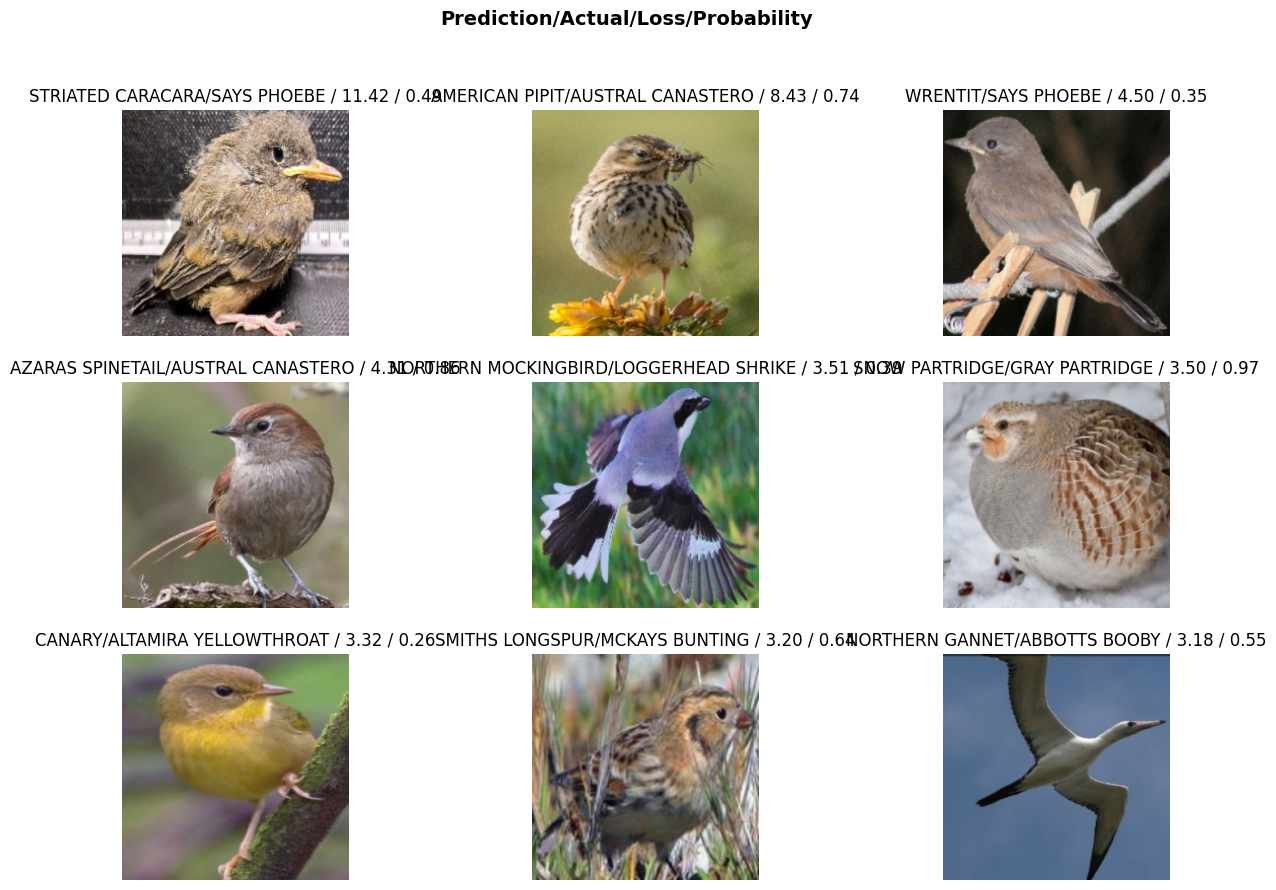

In [14]:
# Plot top lossses
interp.plot_top_losses(k=9, figsize=(15,10)) # pred/actual/loss/prob

In [ ]:
# Plot Confusion Matric
interp.plot_confusion_matrix(figsize=(16,16), dpi=60)

# Unfreeze Model, Fine Tune, Learning Rate

In [ ]:
# Load a previously trained model ('model1_freezed')
learn.load('model1_freezed')

# Find the optimal learning rates for fine-tuning
learn.lr_find()

In [ ]:
# Define a learning rate range (slice) for fine-tuning
lr = slice(1e-5, 1e-4)

In [ ]:
# Unfreeze the model to allow all layers to be trained
learn.unfreeze()

# Fine-tune the model for 4 epochs with a learning rate within the defined range
learn.fit_one_cycle(5, lr_max=lr)

# Save the fine-tuned model with the name 'model2_unfreezed'
learn.save('model2_unfreezed')

## Model Interpretation

In [ ]:
# Model Interpretation
from fastai.interpret import ClassificationInterpretation

interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

print(len(fastai_dls.valid_ds)==len(losses)==len(idxs))

# Classification Report
interp.print_classification_report()

In [ ]:
# Most Confused
interp.most_confused()

## Deployment

In [ ]:
# We will export all the required files and variables that will be necessary for making inference

# Export the fastai learner (model) for inference
learn.export("pets_breed_learner.pkl")

# Export the Pets Breed Vocabular (Class Names)
# Assuming fastai_dls.vocab is a list or object that you want to export
vocab = dls.vocab

# Save the vocab to the pickle file
with open("pets_breed_vocab.pkl", "wb") as f:
    pickle.dump(obj=vocab, file=f)

## Save model for deployment

In [ ]:
import torch
traced_model = torch.jit.script(learn.model.cpu())
traced_model.save("model2_unfreezed_ts.pt")

In [ ]:
!wget -O out.jpg "https://th.bing.com/th/id/OIP.WZoNdVGy2N28WT1uWGP05QHaLH?w=127&h=190&c=7&r=0&o=5&dpr=2&pid=1.7"

In [ ]:
# Load the script module
traced_model = torch.jit.load("model2_unfreezed_ts.pt")

In [ ]:
from PIL import Image
image_path = "/kaggle/working/out.jpg"
image = Image.open("/kaggle/working/out.jpg")
image

In [ ]:
learn.export("learner.pkl")

In [ ]:
import pickle

# Assuming fastai_dls.vocab is a list or object that you want to export
vocab = fastai_dls.vocab

# Save the vocab to the pickle file
with open("vocab.pkl", "wb") as vocab_file:
    pickle.dump(vocab, vocab_file)

In [ ]:
learn.load("model2_unfreezed")

In [ ]:
learn.load("model2_unfreezed")
output = learn.predict(input_image)
output[0]

## Interpretation

In [ ]:
learn.load('model2_unfreezed');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(3, figsize=(9,9))